# Krypton selection

### Run 5882: 
- Open castle, recover lifetime
- pressure: 10 bar
- Gate voltage: 8 kV

### Selection of events in terms of S1 and S2

In [1]:
import os
import time
import glob
import datetime
import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro.hst_functions  import shift_to_bin_centers

from icaro.core.fit_functions import fit_slices_1d_gauss
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:
import core.kr_s1s2_functions as krf
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_plt_functions as krp

In [3]:
from core.kr_types import kr_event
from core.kr_types import kr_times_ranges_and_bins

### Init

In [4]:
path = f"/Users/jjgomezcadenas/Projects/ICDEV/kdst"
opath = f"/Users/jjgomezcadenas/Projects/ICDEV/dst"
run_number          = 5883
input_dst_filenames = f"{path}/{run_number}/kdst*.h5"
input_dst_filename  = f"{path}/{run_number}/kdst_{run_number}.h5"

kdstFiles ='Multiple'  # set to 'Single' if only one kdst

print(f"run number = {run_number}")
print(f"input dsts = {input_dst_filenames}")


run number = 5883
input dsts = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5883/kdst*.h5


In [5]:
output_dst_filename  = f"{opath}/dst_{run_number}.h5"
print(f"output dst = {output_dst_filename}")

output dst = /Users/jjgomezcadenas/Projects/ICDEV/dst/dst_5883.h5


In [6]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Wed Jun 27 21:12:27 2018


In [7]:
def load_dsts(dst_list, group, node):
    dsts=[]
    for filename in dst_list:
        #print(f'loading {filename}')
        try: 
            dsts.append(dstio.load_dst(filename, group, node))
        except:
            print(f' error loading {filename}')
    
    print('done loading')
    return pd.concat(dsts)


In [8]:
if kdstFiles == 'Multiple':
    dst_full           = dstio.load_dsts(glob.glob(input_dst_filenames), "DST", "Events")
else:
    dst_full           = dstf.load_dst(input_dst_filename, "DST", "Events")

In [9]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 1263375 
Total number of events: 1119551


In [10]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [11]:
ntot = len(dst_full)

 0S2/tot  = 0.0 1S2/tot = 1.0 2S2/tot = 0.0


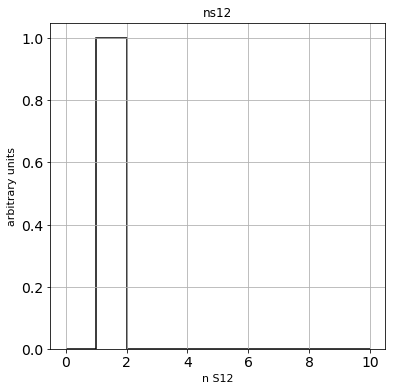

In [12]:
krf.ns12(dst_full, type='S1')

 0S2/tot  = 0.0 1S2/tot = 0.7830794498862175 2S2/tot = 0.1860239438013258


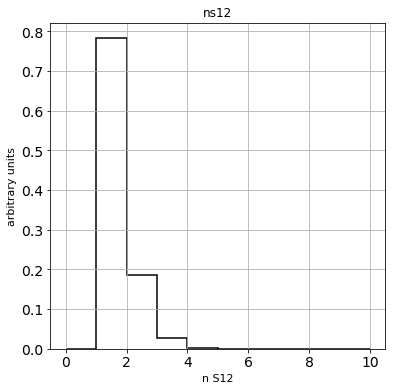

In [13]:
krf.ns12(dst_full, type='S2')

In [14]:
krf.print_ns12_stats(*krf.ns1_stats(dst_full))

ns12: mean =  1.00 sigma =  0.00
ns12 : fraction
0:  0.00
1:  1.00
2:  0.00
3:  0.00
4:  0.00


In [15]:
krf.print_ns12_stats(*krf.ns2_stats(dst_full))

ns12: mean =  1.25 sigma =  0.51
ns12 : fraction
0:  0.00
1:  0.78
2:  0.19
3:  0.03


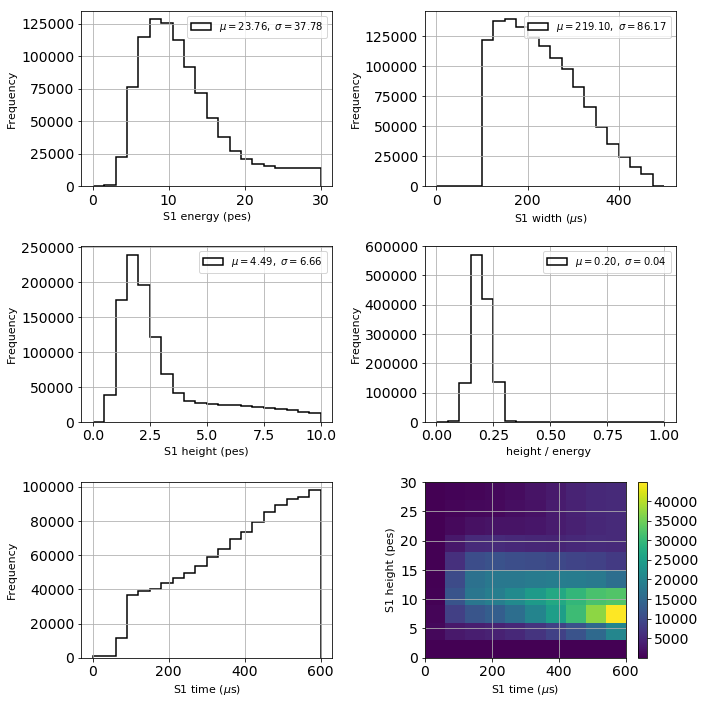

In [16]:
krf.plot_s1histos(dst_full, bins=20, figsize=(10,10))

## Select events with only 1 s1 and 1 s2

In [17]:
dst1s1 = dst_full[dst_full.nS1==1]
dst    = dst1s1[dst1s1.nS2==1]

In [18]:
number_of_events  = len(dst)
eff = number_of_events  / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {number_of_events}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 989323: selection eff = 0.7830794498862175 


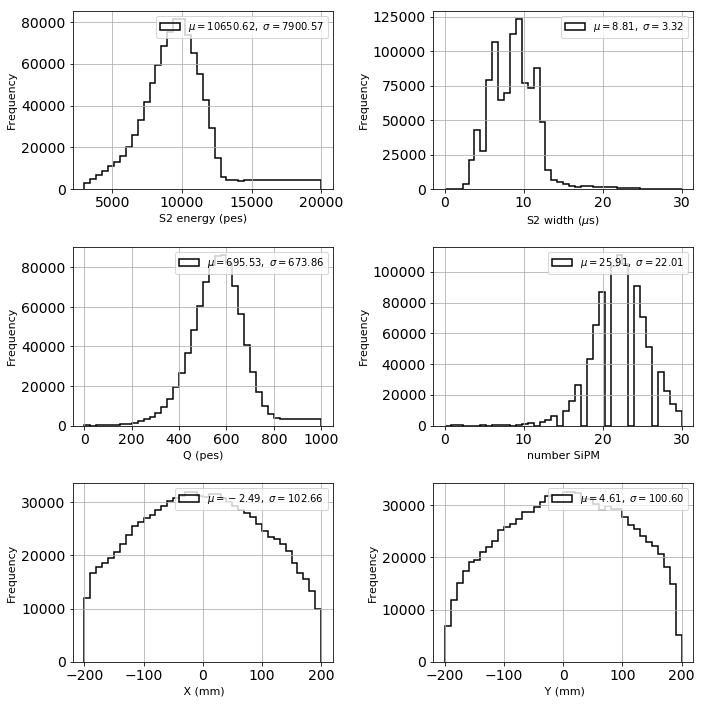

In [19]:
krf.plot_s2histos(dst, bins=40, emin=3000, emax=20000, figsize=(10,10))

### Binning

In [20]:
krTimes, krRanges, krNBins, krBins = kr_times_ranges_and_bins(dst,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-220,  220),
                                                              Erange  = ( 2e3, 15e3),
                                                              S1range = (   0,   30),
                                                              Qrange  = ( 100, 1500),
                                                              Znbins        =   10,
                                                              XYnbins       =   60,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

In [21]:
print(krRanges, krNBins)

KrRanges(E=(2000.0, 15000.0), S1=(0, 30), Q=(100, 1500), Z=(100, 550), T=(datetime.datetime(2018, 6, 23, 13, 4, 42, 567000), datetime.datetime(2018, 6, 24, 11, 11, 20, 123000)), XY=(-220, 220)) KrNBins(E=50, S1=20, Q=25, Z=10, T=22, XY=60)


In [22]:
kdst = kr_event(dst)

In [23]:
XYpitch    = np.diff(krBins.XY)[0] 

### Fiducial volumes

In [24]:
R_full   = 190
R_fid    = 150
R_core   = 100
R_hcore  =  50
print(f" Rfull : {R_full}: Rfiducial : {R_fid}: Rcore = {R_core} Rhcore = {R_hcore} ")

 Rfull : 190: Rfiducial : 150: Rcore = 100 Rhcore = 50 


In [25]:
n_dst  = len(dst)
dst_full   = dst[dst.R < R_full]
dst_fid    = dst[dst.R < R_fid]
dst_core   = dst[dst.R < R_core]
dst_hcore  = dst[dst.R < R_hcore]
n_full     = len(dst_full)
n_fid      = len(dst_fid)
n_core     = len(dst_core)
n_hcore    = len(dst_hcore)

eff_full   = n_full  / n_dst
eff_fid    = n_fid   / n_dst
eff_core   = n_core  / n_dst
eff_hcore  = n_hcore / n_dst

print(f" nfull : {n_full}: eff_full = {eff_full} ")
print(f" nfid : {n_fid}: eff_fid = {eff_fid} ")
print(f" ncore : {n_core}: eff_core = {eff_core} ")
print(f" nhcore : {n_hcore}: eff_hcore = {eff_hcore} ")

 nfull : 877857: eff_full = 0.8873310334440825 
 nfid : 533602: eff_fid = 0.539360754778773 
 ncore : 234838: eff_core = 0.23737242538584466 
 nhcore : 59091: eff_hcore = 0.05972872358168162 


In [26]:
kfull = kr_event(dst_full)
kfid = kr_event(dst_fid)
kcore= kr_event(dst_core)
khcore = kr_event(dst_hcore)

### Event distributions

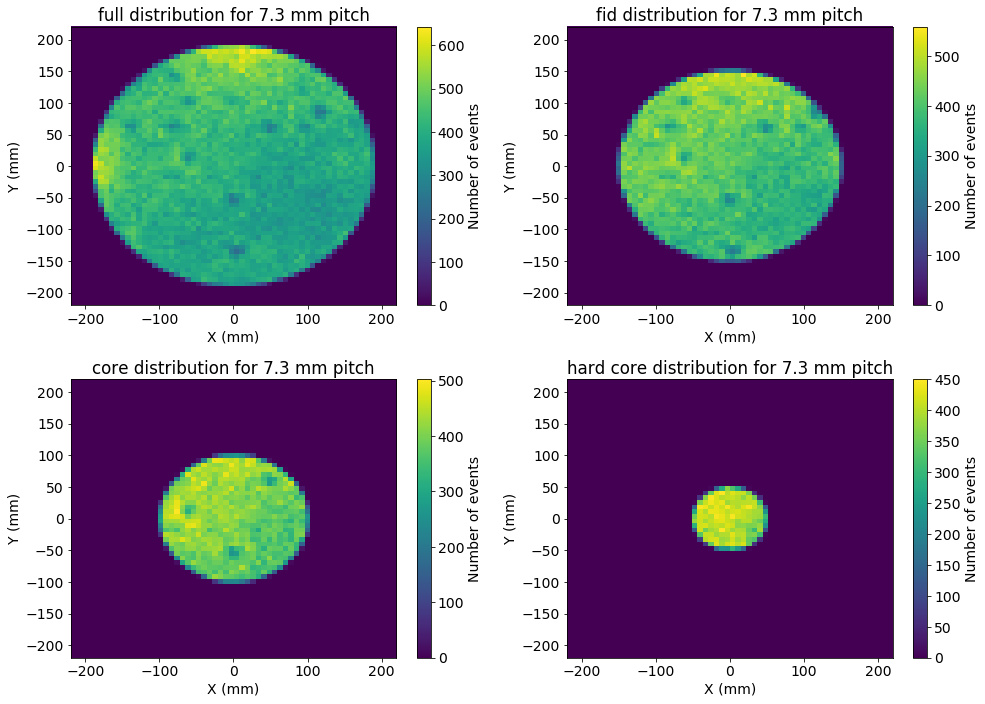

In [27]:
fig = plt.figure(figsize=(14,10))
fig.add_subplot(2, 2, 1)
nevt, *_ = plt.hist2d(kfull.X, kfull.Y, (krBins.XY, krBins.XY))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"full distribution for {XYpitch:.1f} mm pitch")
fig.add_subplot(2, 2, 2)
nevt, *_ = plt.hist2d(kfid.X, kfid.Y, (krBins.XY, krBins.XY))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"fid distribution for {XYpitch:.1f} mm pitch")
fig.add_subplot(2, 2, 3)
nevt, *_ = plt.hist2d(kcore.X, kcore.Y, (krBins.XY, krBins.XY))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"core distribution for {XYpitch:.1f} mm pitch")
fig.add_subplot(2, 2, 4)
nevt, *_ = plt.hist2d(khcore.X, khcore.Y, (krBins.XY, krBins.XY))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"hard core distribution for {XYpitch:.1f} mm pitch")
plt.tight_layout()

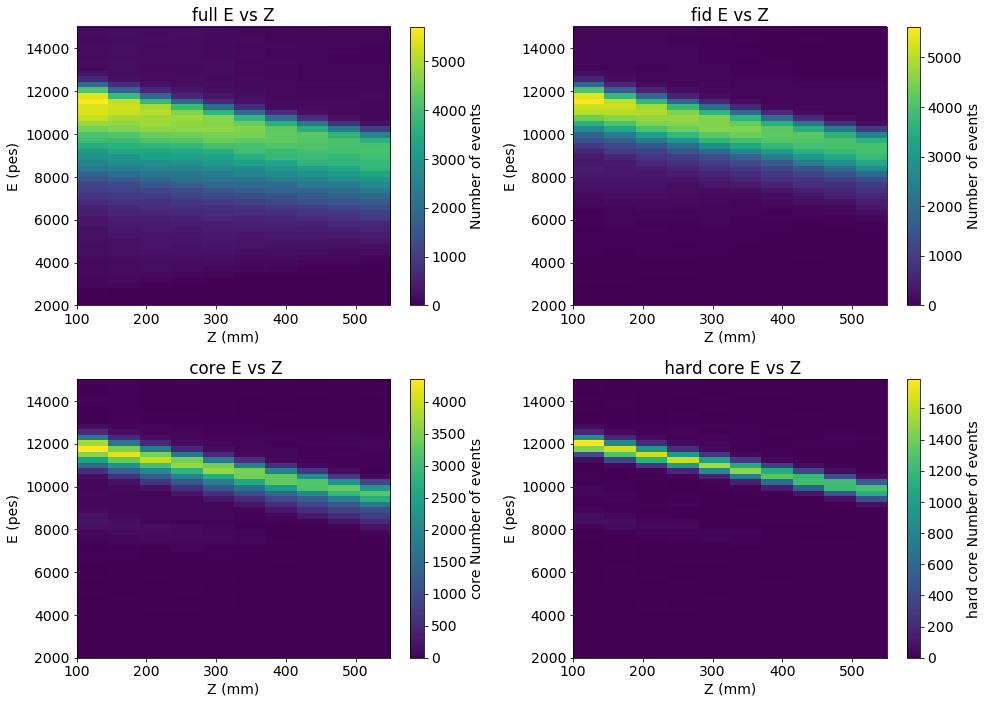

In [28]:
fig = plt.figure(figsize=(14,10))
fig.add_subplot(2, 2, 1)
nevt, *_  = plt.hist2d(kfull.Z, kfull.E, (krBins.Z, krBins.E))
plt.colorbar().set_label("Number of events")
labels("Z (mm)", "E (pes)", f"full E vs Z")
fig.add_subplot(2, 2, 2)
nevt, *_  = plt.hist2d(kfid.Z, kfid.E, (krBins.Z, krBins.E))
plt.colorbar().set_label("Number of events")
labels("Z (mm)", "E (pes)", f"fid E vs Z")
fig.add_subplot(2, 2, 3)
nevt, *_  = plt.hist2d(kcore.Z, kcore.E, (krBins.Z, krBins.E))
plt.colorbar().set_label("core Number of events")
labels("Z (mm)", "E (pes)", f" core E vs Z")
fig.add_subplot(2, 2, 4)
nevt, *_  = plt.hist2d(khcore.Z, khcore.E, (krBins.Z, krBins.E))
plt.colorbar().set_label("hard core Number of events")
labels("Z (mm)", "E (pes)", f" hard core E vs Z")
plt.tight_layout()

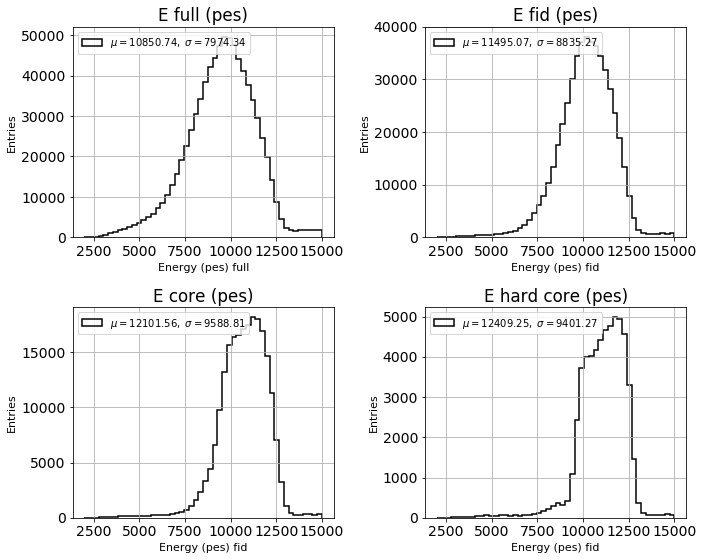

In [29]:
krh.h1n(n=4, nx=2, ny=2, 
    h1ds = (kfull.E, kfid.E, kcore.E, khcore.E),
    bins = (krNBins.E, krNBins.E, krNBins.E, krNBins.E),
    ranges = (krRanges.E, krRanges.E, krRanges.E, krRanges.E),
    xlabels = ("Energy (pes) full", "Energy (pes) fid", "Energy (pes) fid", "Energy (pes) fid"),
    ylabels = ("Entries", "Entries", "Entries", "Entries"),
    titles = ("E full (pes)", "E fid (pes)", "E core (pes)", "E hard core (pes)"),
    legends = ("upper left", "upper left", "upper left", "upper left"),
    figsize =(10,8))

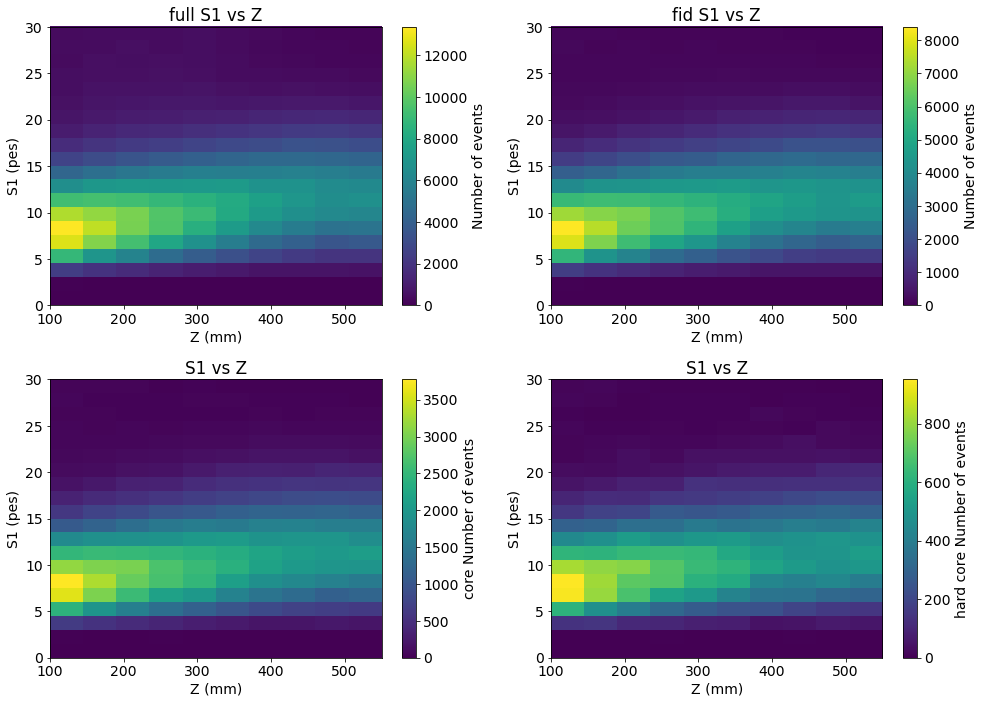

In [30]:
fig = plt.figure(figsize=(14,10))
fig.add_subplot(2, 2, 1)
nevt, *_  = plt.hist2d(kfull.Z, kfull.S1, (krBins.Z, krBins.S1))
plt.colorbar().set_label("Number of events")
labels("Z (mm)", "S1 (pes)", f"full S1 vs Z")
fig.add_subplot(2, 2, 2)
nevt, *_  = plt.hist2d(kfid.Z, kfid.S1, (krBins.Z, krBins.S1))
plt.colorbar().set_label("Number of events")
labels("Z (mm)", "S1 (pes)", f"fid S1 vs Z")
fig.add_subplot(2, 2, 3)
nevt, *_  = plt.hist2d(kcore.Z, kcore.S1, (krBins.Z, krBins.S1))
plt.colorbar().set_label("core Number of events")
labels("Z (mm)", "S1 (pes)", f"S1 vs Z")
fig.add_subplot(2, 2, 4)
nevt, *_  = plt.hist2d(khcore.Z, khcore.S1, (krBins.Z, krBins.S1))
plt.colorbar().set_label("hard core Number of events")
labels("Z (mm)", "S1 (pes)", f"S1 vs Z")
plt.tight_layout()

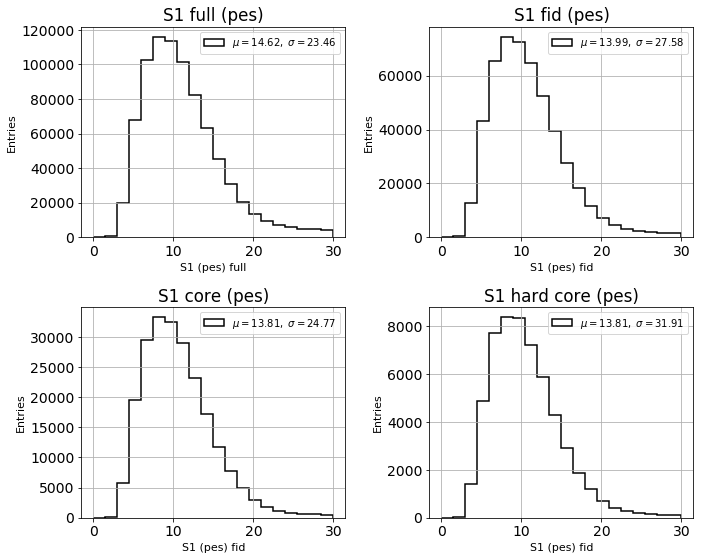

In [31]:
krh.h1n(n=4, nx=2, ny=2, 
    h1ds = (kfull.S1, kfid.S1, kcore.S1, khcore.S1),
    bins = (krNBins.S1, krNBins.S1, krNBins.S1, krNBins.S1),
    ranges = (krRanges.S1, krRanges.S1, krRanges.S1, krRanges.S1),
    xlabels = ("S1 (pes) full", "S1 (pes) fid", "S1 (pes) fid", "S1 (pes) fid"),
    ylabels = ("Entries", "Entries", "Entries", "Entries"),
    titles = ("S1 full (pes)", "S1 fid (pes)", "S1 core (pes)", "S1 hard core (pes)"),
    legends = ("upper right", "upper right", "upper right", "upper right"),
    figsize =(10,8))

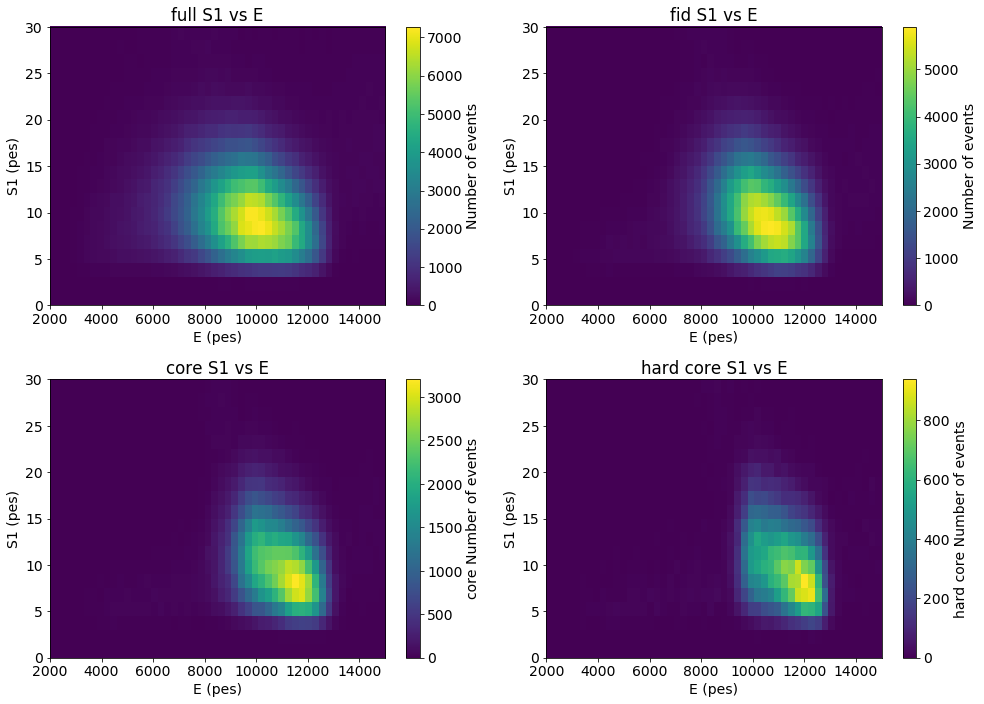

In [32]:
fig = plt.figure(figsize=(14,10))
fig.add_subplot(2, 2, 1)
nevt, *_  = plt.hist2d(kfull.E, kfull.S1, (krBins.E, krBins.S1))
plt.colorbar().set_label("Number of events")
labels("E (pes)", "S1 (pes)", f"full S1 vs E")
fig.add_subplot(2, 2, 2)
nevt, *_  = plt.hist2d(kfid.E, kfid.S1, (krBins.E, krBins.S1))
plt.colorbar().set_label("Number of events")
labels("E (pes)", "S1 (pes)", f"fid S1 vs E")
fig.add_subplot(2, 2, 3)
nevt, *_  = plt.hist2d(kcore.E, kcore.S1, (krBins.E, krBins.S1))
plt.colorbar().set_label("core Number of events")
labels("E (pes)", "S1 (pes)", f"core S1 vs E")
fig.add_subplot(2, 2, 4)
nevt, *_  = plt.hist2d(khcore.E, khcore.S1, (krBins.E, krBins.S1))
plt.colorbar().set_label("hard core Number of events")
labels("E (pes)", "S1 (pes)", f"hard core S1 vs E")
plt.tight_layout()

In [33]:
S2_min = 6000
S2_max = 14000
S1_min = 2
S1_max = 25

dst_sel_S2   = dst_full[in_range(dst_full.S2e, S2_min, S2_max)]
dst_sel_S1   = dst_sel_S2[in_range(dst_sel_S2.S1e, S1_min, S1_max)]

n_S2       = len(dst_sel_S2)
n_S1       = len(dst_sel_S1)

eff_S2   = n_S2 / n_full 
eff_S1   = n_S1 / n_full

print(f" nS2 : {n_S2}: eff_S2 = {eff_S2} ")
print(f" nS1 : {n_S1}: eff_S1 = {eff_S1} ")

 nS2 : 770798: eff_S2 = 0.8780450574524097 
 nS1 : 740929: eff_S1 = 0.8440201536241096 


In [34]:
dst        = dst_sel_S1
dst_full   = dst[dst.R < R_full]
dst_fid    = dst[dst.R < R_fid]
dst_core   = dst[dst.R < R_core]
dst_hcore  = dst[dst.R < R_hcore]
kfull = kr_event(dst_full)
kfid = kr_event(dst_fid)
kcore= kr_event(dst_core)
khcore = kr_event(dst_hcore)

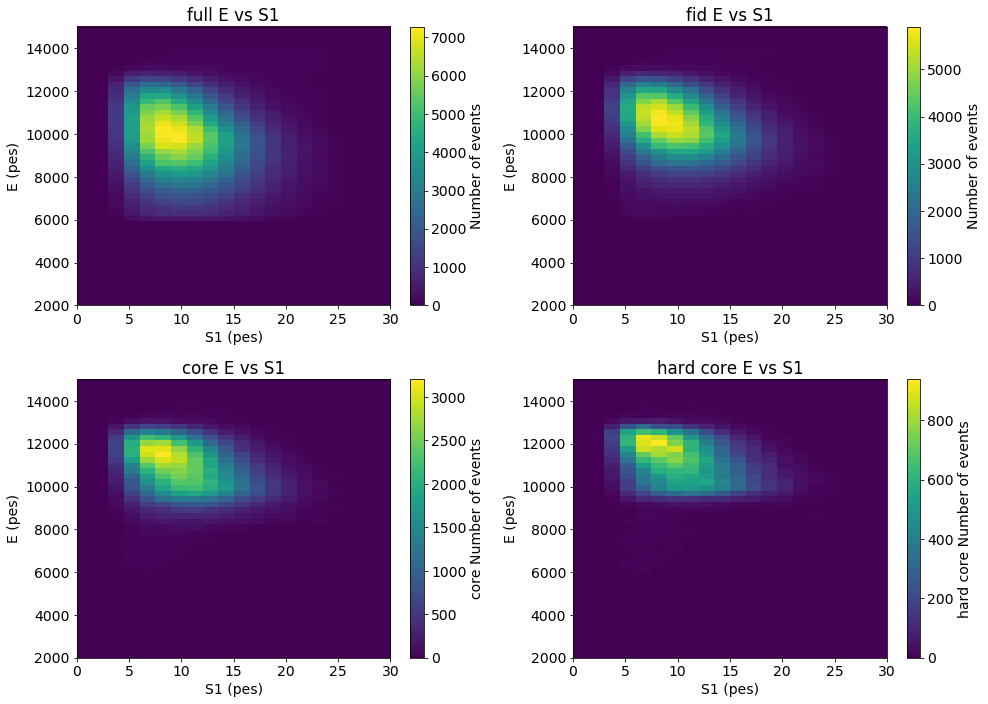

In [35]:
fig = plt.figure(figsize=(14,10))
fig.add_subplot(2, 2, 1)
nevt, *_  = plt.hist2d(kfull.S1, kfull.E, (krBins.S1, krBins.E))
plt.colorbar().set_label("Number of events")
labels("S1 (pes)", "E (pes)", f"full E vs S1")
fig.add_subplot(2, 2, 2)
nevt, *_  = plt.hist2d(kfid.S1, kfid.E, (krBins.S1, krBins.E))
plt.colorbar().set_label("Number of events")
labels("S1 (pes)", "E (pes)", f"fid E vs S1")
fig.add_subplot(2, 2, 3)
nevt, *_  = plt.hist2d(kcore.S1, kcore.E, (krBins.S1, krBins.E))
plt.colorbar().set_label("core Number of events")
labels("S1 (pes)", "E (pes)", f"core E vs S1")
fig.add_subplot(2, 2, 4)
nevt, *_  = plt.hist2d(khcore.S1, khcore.E, (krBins.S1, krBins.E))
plt.colorbar().set_label("hard core Number of events")
labels("S1 (pes)", "E (pes)", f"hard core E vs S1")
plt.tight_layout()

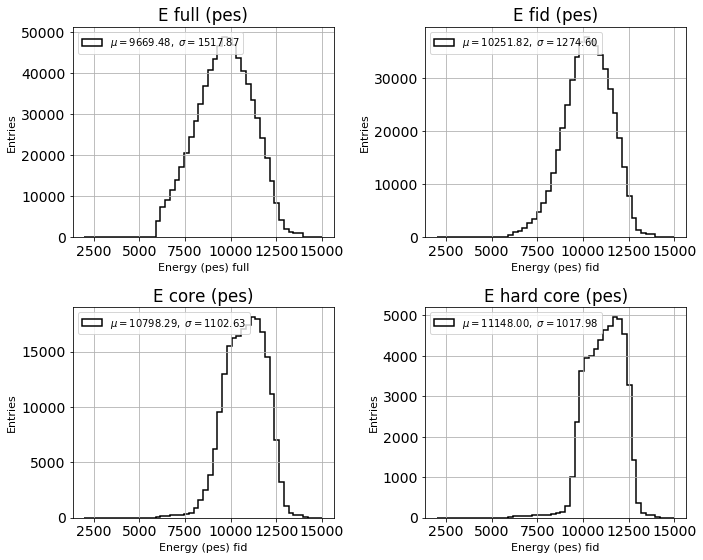

In [36]:
krh.h1n(n=4, nx=2, ny=2, 
    h1ds = (kfull.E, kfid.E, kcore.E, khcore.E),
    bins = (krNBins.E, krNBins.E, krNBins.E, krNBins.E),
    ranges = (krRanges.E, krRanges.E, krRanges.E, krRanges.E),
    xlabels = ("Energy (pes) full", "Energy (pes) fid", "Energy (pes) fid", "Energy (pes) fid"),
    ylabels = ("Entries", "Entries", "Entries", "Entries"),
    titles = ("E full (pes)", "E fid (pes)", "E core (pes)", "E hard core (pes)"),
    legends = ("upper left", "upper left", "upper left", "upper left"),
    figsize =(10,8))

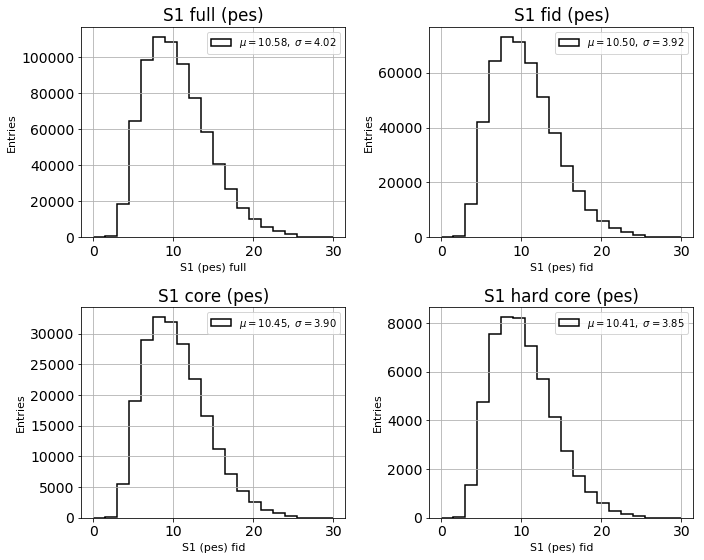

In [37]:
krh.h1n(n=4, nx=2, ny=2, 
    h1ds = (kfull.S1, kfid.S1, kcore.S1, khcore.S1),
    bins = (krNBins.S1, krNBins.S1, krNBins.S1, krNBins.S1),
    ranges = (krRanges.S1, krRanges.S1, krRanges.S1, krRanges.S1),
    xlabels = ("S1 (pes) full", "S1 (pes) fid", "S1 (pes) fid", "S1 (pes) fid"),
    ylabels = ("Entries", "Entries", "Entries", "Entries"),
    titles = ("S1 full (pes)", "S1 fid (pes)", "S1 core (pes)", "S1 hard core (pes)"),
    legends = ("upper right", "upper right", "upper right", "upper right"),
    figsize =(10,8))

### Write DST (merged and fiducial)

In [ ]:
#del dst['index']

In [ ]:
# Unfortunately, this method can't set a specific name to the table or its title.
# It also includes an extra column ("index") which I can't manage to remove.
dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)



In [ ]:
# Workaround to re-establish the name of the table and its title
with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"